In [77]:
#! pip install win32gui

Finding the window. Poker client

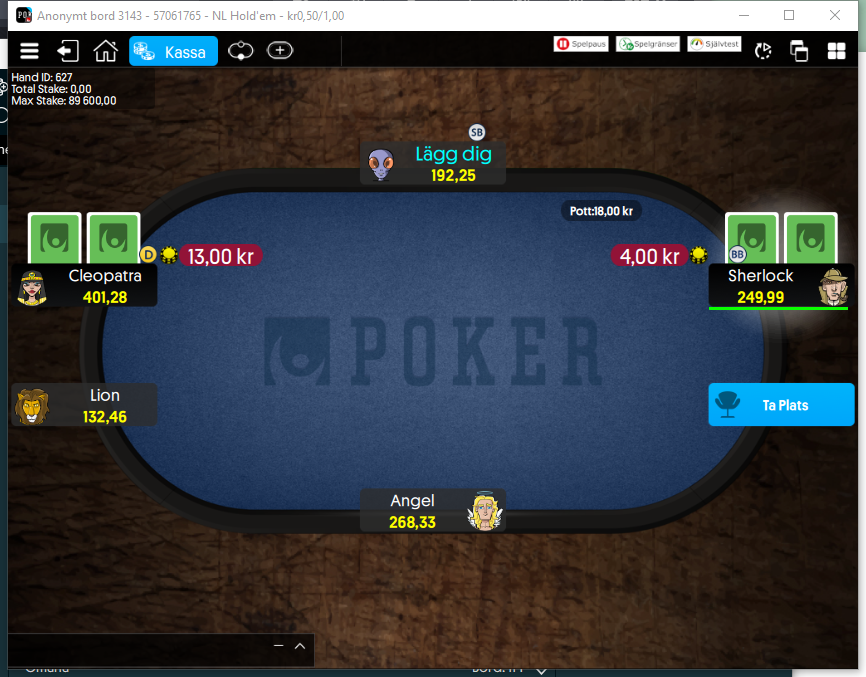

True

In [83]:
import win32gui
from PIL import Image, ImageGrab
import re
# take id from client input
id = input("Enter the ID: ")
# Define a regular expression pattern to match the ID in the window title
id_pattern = r"\b" + id + r"\b"

# Find the window handle of the table by matching on the ID in the title
def find_table_window_handle():
    window_handle = None
    def callback(hwnd, regex):
        title = win32gui.GetWindowText(hwnd)
        if re.search(regex, title):
            nonlocal window_handle
            window_handle = hwnd
    win32gui.EnumWindows(callback, id_pattern)
    return window_handle

# Capture a screenshot of the table window
def capture_table_screenshot():
    window_handle = find_table_window_handle()
    if window_handle:
        screenshot = ImageGrab.grab(win32gui.GetWindowRect(window_handle))
        screenshot.save("table_screenshot.png")
        display(screenshot)
        return True
    else:
        return False

# Call the capture_table_screenshot function to capture the screenshot
capture_table_screenshot()



Identifying seats and cash stacks

In [79]:
#! pip install pytesseract
#! pip install opencv-python

Player boxes: [(405, 143, 513, 184), (9, 263, 159, 309), (6, 383, 156, 426), (466, 489, 612, 531)]
Player screenshot:


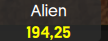

Player screenshot:


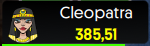

Player screenshot:


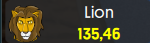

Player screenshot:


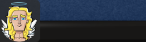

In [80]:
import win32gui
from PIL import Image, ImageGrab, ImageOps
import pytesseract
import re
import cv2
import numpy as np
import os

# Identify the positions of all player boxes in the table screenshot
def identify_player_boxes():
    table_screenshot = cv2.imread("table_screenshot.png", 0)

    # all player box templates - ie all png in the folder
    # folder name player_box_templates
    player_box_templates = []
    for png in os.listdir("player_box_templates"):
        if png.endswith(".png"):
            player_box_templates.append(cv2.imread("player_box_templates/" + png, 0))

    player_boxes = []
    for template in player_box_templates:
        w, h = template.shape[::-1]
        res = cv2.matchTemplate(table_screenshot, template, cv2.TM_CCOEFF_NORMED)
        threshold = 0.6
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            player_box = (pt[0], pt[1], pt[0] + w, pt[1] + h)
            if not any([overlap(player_box, pb) for pb in player_boxes]):
                player_boxes.append(player_box)
    return player_boxes


# Check if two rectangles overlap
def overlap(rect1, rect2):
    return not (rect1[2] <= rect2[0] or rect1[0] >= rect2[2] or rect1[3] <= rect2[1] or rect1[1] >= rect2[3])


# Call the capture_table_screenshot, identify_player_boxes, and extract_stack_size functions to identify all player profiles and their respective positions and stack sizes
player_boxes = identify_player_boxes()
print("Player boxes:", player_boxes)

# save screenshot of each player box
for i, player_box in enumerate(player_boxes):
    player_screenshot = Image.open("table_screenshot.png").crop(player_box)
    # display
    print("Player screenshot:")
    display(player_screenshot)

From the players. Get the current balance

In [81]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

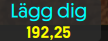

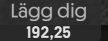

Lagg dig
192,25

['192,25']
Stack size: 192.25


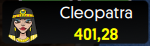

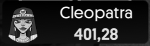

= Cleopatra
Se 40128

['401', '28']


IndexError: pop from empty list

In [87]:
import cv2
import numpy as np
from PIL import Image, ImageOps

# Preprocess the player box image to extract the stack size. Do not use pytesseract
def extract_stack_size(player_box):
    player_screenshot = Image.open("table_screenshot.png").crop(player_box)
    # convert to grayscale
    player_screenshot = player_screenshot.convert("L")
    
    display(player_screenshot)
    # extract the text using pytesseract
    data = pytesseract.image_to_string(player_screenshot, config="--psm 6")
    print(data)
    data = re.findall(r"\d{1,3}(?:,\d{2})?", data)
    print(data)
    # get the element with a comma. THIS CAN BE IMPROVED
    stack = [d for d in data if "," in d].pop()
    return float(stack.replace(",", "."))

### TEST ####
for player_box in player_boxes:
    player_screenshot = Image.open("table_screenshot.png").crop(player_box)
    display(player_screenshot)

    stack = extract_stack_size(player_box)
    print("Stack size:", stack)